## 15<sup>th</sup> of April, 2020
## Benjamin Adam Catching
## Coronavirus Simulation
## Andino Lab

In [1]:
# Import python packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import scipy

Now that the simulation script has been standardized and updated to the most recent build it is time to add correct parameters. As of now, when a susceptible agent interacts with a infected agent the susceptible agent immediately becomes infected and transmits the pathogen. To reflect real world data, the susceptible agent should incubate the virus for a period of time then become infectious. If the agent is symptomatic the incubation is 4.6 days followed by 12 hours of being infectious before 'isolating/hospitalizing'. If the agent is asymptomatic the incubation is 5.1 days followed by 14 days of being infectious at 66% of the symptomatic rate.  

The density and velocities will then be adjusted such that the calculated R<sub>o</sub> value, from symptomatic individuals, is near 2.5. The R<sub>o</sub> will be calculated from simulated data by methods from <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2760158/">Lipsitch et. al, _Science_. 2003</a>.  

First import the latest iteration of the simulation script.

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


Traceback (most recent call last):
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-36-2e1a7f078cd2>", line 262, in update
    f.write(temp_write)
ValueError: I/O operation on closed file.


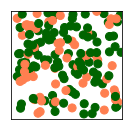

In [36]:
# Name the datafile
run_name = 'asympt_test_02'
dataname = '../../data/' + run_name + '.csv'
f = open(dataname, 'w')
# Write header of the file
f.write('# Data from simulation of 200 agents with various levels\
 of sheltering or mask usage\n')
f.write('time,percent sheltering,percent wearing masks,infected,recovered,\
exposed,infected with mask,susceptible with mask\n')

        
"""Values of the simulation"""
# Fixing random state for reproducibility
np.random.seed(100)

# Figure ratio
fig_rat = .2
# Set boundaries
xboundaries = [0, 50 * fig_rat]
yboundaries = [0, 50 * fig_rat]
xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5

# Number of steps
N_steps = 720
# Number of agents
n_agents = int(4000 * round(fig_rat ** 2, 2))
# Set delta t
dt = 1
# Set velocity
velo = .2
# Set percent of sheltering in place
per_shelt = 0
# Set percent of masked agents
per_mask = 0

# Define the array of agents with given properties
agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                   ('velocity', float, 2),
                                   ('color', str, 20),
                                   ('state', str, 20),
                                   ('time', int, 1),
                                   ('symptomatic', int, 1),
                                   ('num infected', int, 1),
                                   ('mask', bool, 1),
                                   ('touch', int, 1)])



"""Calculate initial values of agents"""
# Define the initial random positions within the figure
agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))
# Define the initial velocity angles
init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
# Get initial x and y velocities from angles
velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) 
velocities *= velo
# Get percentage of agents 'sheltering'
num_shelt = int(per_shelt * n_agents)
# Make sheltering agents static (if any)
velocities[:num_shelt] = np.zeros((num_shelt, 2))
# Number of hours for asymptomatic incubation
asympt_incubate = 24 * 5.1
# Number of hours for symptomatic incubation
sympt_incubate = 24 * 4.6
# Number of hours for asymptomatic infection
asympt_infect = 14*24
# Number of hours for symptomatic infection
sympt_infect = 12
# Define values for infection gamma pdf
g_shape, g_scale = 0.25, 4
# Probability reduction for asymptomatic carrier
asym_prob = .66


"""Assign values to agents"""
# Assign velocities
agents['velocity'] = velocities
# Assign color (Navy is the default susceptible agent)
agents['color'] = np.array(['Navy'] * n_agents)
# Set agents to be symptomatic
agents['state'] = np.array(['Susceptible'] * n_agents)
agents['time'] = np.array([0] * n_agents)
n_mask = [True] * per_mask + [False] * (10-per_mask)
agents['mask'] = np.random.choice(n_mask, n_agents, replace=True)
agents['color'][agents['mask'] == True] = 'Dodgerblue'
agents['symptomatic'] = np.zeros(n_agents)
agents['num infected'] = np.zeros(n_agents)

# Make the one agent infected
agents['color'][0] = 'Violet'
agents['state'][0] = 'Exposed'
agents['time'][0] = 1
agents['mask'][0] = False
agents['symptomatic'][0] = 1


"""Define the values of the display"""
# Define the figure
fig = plt.figure(figsize=(10 * fig_rat, 10 * fig_rat))
ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
plt.xticks([])
plt.yticks([])

# Initialize the plot
scatter = ax.scatter(agents['position'][:, 0], 
                     agents['position'][:, 1],
                     color=agents['color'],
                     s=64)

def update(i):
    """
    Take the information from the data stored in the agents array
    to calculate if an infected agent recovers, if two agents 
    interact, and if the agent bounces off a boundary
    """
    
    print(i)

    # Iterate over all agents 
    for j in range(n_agents):
        if agents['time'][j] != 0:
            # Calculate if agent is exposed or infected
            agent_j_infected = agents['state'][j] == 'Infected'
            agent_j_exposed = agents['state'][j] == 'Exposed'
            # Store time agent has been in this state
            agent_j_time = agents['time'][j]
            # Calculate if the agent is symptomatic or not
            agent_j_sympt = agents['symptomatic'][j]
            if agent_j_infected and agent_j_sympt:
                if agents['time'][j] >= sympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_infected and not agent_j_sympt:
                if agents['time'][j] >= asympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and agent_j_sympt:
                if agents['time'][j] >= sympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Firebrick'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and not agent_j_sympt:
                if agents['time'][j] >= asympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Coral'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
                
        # New displacements (prior velocity times change in time)
        deltax_temp = dt * agents['velocity'][j, 0]
        deltay_temp = dt * agents['velocity'][j, 1]
        # New positions
        x = agents['position'][j, 0] + deltax_temp
        y = agents['position'][j, 1] + deltay_temp
        # Compute new velocity
        vx_temp = deltax_temp / dt
        vy_temp = deltay_temp / dt

        # Add interaction
        for k in range(n_agents):
            # Go through all other agents that could be interacted with
            if k != j:
                # Compute components of distance
                dx = agents['position'][j, 0] - agents['position'][k, 0]
                dy = agents['position'][j, 1] - agents['position'][k, 1]
                # Compute distance between agents
                dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                # If distance of interaction is closer than both radii, collide
                if dist_temp <= 1:
                        agents['touch'][j] += 1
                        if agents['state'][j] == 'Infected' and agents['state'][k] == 'Susceptible':
                            if agents['symptomatic'][j] == 1:
                                if np.random.gamma(shape=g_shape, scale=g_scale) >= 1:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
                            else:
                                if np.random.gamma(shape=g_shape, scale=g_scale) * asym_prob >=1:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                    else:
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
                        elif agents['state'][k] == 'Infected' and agents['state'][j] == 'Susceptible':
                            if agents['symptomatic'][k] == 1:
                                if np.random.gamma(shape=g_shape, scale=g_scale) >= 1:
                                    agents['state'][j] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][j] = 1
                                        agents['color'][j] = 'Violet'
                                    else:
                                        agents['symptomatic'][j] = 0
                                        agents['color'][j] = 'Indigo'
                                    agents['time'][j] = 1
                                    agents['num infected'][k] += 1
                            else:
                                if np.random.gamma(shape=g_shape, scale=g_scale) * asym_prob >=1:
                                    agents['state'][j] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][j] = 1
                                        agents['color'][j] = 'Violet'
                                    else:
                                        agents['symptomatic'][j] = 0
                                        agents['color'][j] = 'Indigo'
                                    agents['time'][j] = 1
                                    agents['num infected'][k] += 1

        # Bounce agents off wall if projected position is beyond boundary conditions
        if x >= xmax:
            x = 2 * xmax - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif x <= 0:
            x = - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif y >= ymax:
            y = 2 * ymax - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        elif y <= 0:
            y = - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1

        # 
        agents['position'][j] = np.array([x, y])
        agents['velocity'][j, 0] = vx_temp
        agents['velocity'][j, 1] = vy_temp

        # Update the scatter collection, with the new colors, sizes and positions.
        scatter.set_color(agents['color'])
        scatter.set_offsets(agents['position'])

    # Get values of the current time step
    temp_infected = sum(agents['state']=='Infected')
    temp_recovered = sum(agents['state']=='Recovered')
    temp_infect_mask = sum(agents[agents['mask']==True]['state'] == 'Infected')
    temp_suscept_mask = sum(agents[agents['mask']==True]['state'] == 'Susceptible')
    temp_exposed = sum(agents['state']=='Exposed')
    temp_write = str(i) + ',' + str(round(per_shelt * .1, 1)) + ',' + \
                 str(round(per_mask * .1, 1)) + ',' + str(temp_infected)+ ',' \
                 + str(temp_exposed) + ',' + str(temp_recovered) + ',' + \
                 str(temp_infect_mask) + ',' + str(temp_suscept_mask) \
                 + '\n'
    # Save current data to a file
    f.write(temp_write)

# Animate the simulation by iterating
animation = FuncAnimation(fig, update, frames=N_steps, interval=20)
temp_name = '../../data/' + run_name + '.gif'
animation.save(temp_name, writer='imagemagick')
f.close()

In [41]:
# Read in file
asympt_df = pd.read_csv(dataname, header=1)
print(asympt_df.columns)
asympt_df.head()

Index(['time', 'percent sheltering', 'percent wearing masks', 'infected',
       'recovered', 'exposed', 'infected with mask', 'susceptible with mask'],
      dtype='object')


,time,percent sheltering,percent wearing masks,infected,recovered,exposed,infected with mask,susceptible with mask
0,0,0.0,0.0,0,1,0,0,0
1,1,0.0,0.0,0,1,0,0,0
2,2,0.0,0.0,0,1,0,0,0
3,3,0.0,0.0,0,1,0,0,0
4,4,0.0,0.0,0,1,0,0,0


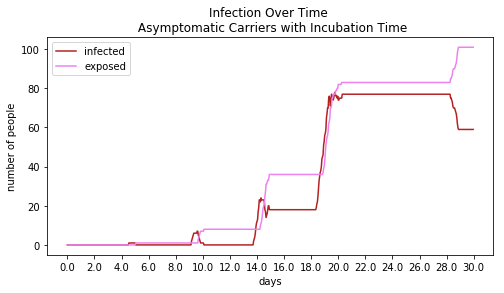

In [44]:
plt.figure(figsize=(8, 4))
plt.plot(asympt_df['time'],
                 asympt_df['infected'],
                 color='firebrick',
                 label='infected')
plt.plot(asympt_df['time'], asympt_df['exposed'], color='violet', label='exposed')
plt.ylabel('number of people')
plt.xlabel('days')
plt.title('Infection Over Time \n Asymptomatic Carriers with Incubation Time')
plt.legend()
plt.xticks(np.linspace(0, 720, 16), np.linspace(0, 30, 16))
plt.savefig('../../data/' + run_name + '.png', dpi=100)
plt.show()

Now to add masks.

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
new asympt
110
111
112
113
114
115
new asympt
new asympt
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
new asympt
224
new asympt
new asympt
225
226
227
228
229
230
new asympt
231
new asympt
new asympt
232
new asympt
new asympt
233
new asympt
new asympt
234
235
236
new asympt
new as

Traceback (most recent call last):
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/adam/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-66-dac68fec2873>", line 320, in update
    f.write(temp_write)
ValueError: I/O operation on closed file.


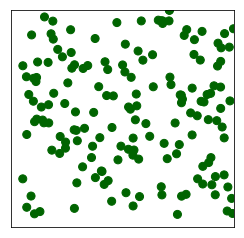

In [66]:
# Name the datafile
run_name = 'asympt_test_mask'
dataname = '../../data/' + run_name + '.csv'
f = open(dataname, 'w')
# Write header of the file
f.write('# Data from simulation of 200 agents with various levels\
 of sheltering or mask usage\n')
f.write('time,percent sheltering,percent wearing masks,infected,\
exposed,recovered,infected with mask,susceptible with mask,\
infected symptomatic,infected asymptomatic\n')

        
"""Values of the simulation"""
# Fixing random state for reproducibility
np.random.seed(42)

# Figure ratio
fig_rat = .2
# Set boundaries
xboundaries = [0, 50 * fig_rat]
yboundaries = [0, 50 * fig_rat]
xmax, ymax = xboundaries[1]+.5 , yboundaries[1]+.5

# Number of steps
N_steps = 960
# Number of agents
n_agents = int(4000 * round(fig_rat ** 2, 2))
# Set delta t
dt = 1
# Set velocity
velo = .2
# Set percent of sheltering in place
per_shelt = 0
# Set percent of masked agents
per_mask = 0

# Define the array of agents with given properties
agents = np.zeros(n_agents, dtype=[('position', float, 2),
                                   ('velocity', float, 2),
                                   ('color', str, 20),
                                   ('state', str, 20),
                                   ('time', int, 1),
                                   ('symptomatic', int, 1),
                                   ('num infected', int, 1),
                                   ('mask', bool, 1),
                                   ('touch', int, 1)])



"""Calculate initial values of agents"""
# Define the initial random positions within the figure
agents['position'] = np.random.uniform(0, xmax, (n_agents, 2))
# Define the initial velocity angles
init_angles = np.random.uniform(0, 2 * np.pi, n_agents)
# Get initial x and y velocities from angles
velocities = np.array([[np.sin(x), np.cos(x)] for x in init_angles]) 
velocities *= velo
# Get percentage of agents 'sheltering'
num_shelt = int(per_shelt * n_agents)
# Make sheltering agents static (if any)
velocities[:num_shelt] = np.zeros((num_shelt, 2))
# Number of hours for asymptomatic incubation
asympt_incubate = 24 * 5.1
# Number of hours for symptomatic incubation
sympt_incubate = 24 * 4.6
# Number of hours for asymptomatic infection
asympt_infect = 14*24
# Number of hours for symptomatic infection
sympt_infect = 12
# Define values for infection gamma pdf
g_shape, g_scale = 0.25, 4
# Probability reduction for asymptomatic carrier
asym_prob = .66


"""Assign values to agents"""
# Assign velocities
agents['velocity'] = velocities
# Assign color (Navy is the default susceptible agent)
agents['color'] = np.array(['Navy'] * n_agents)
# Set agents to be symptomatic
agents['state'] = np.array(['Susceptible'] * n_agents)
agents['time'] = np.array([0] * n_agents)
n_mask = [True] * per_mask + [False] * (10-per_mask)
agents['mask'] = np.random.choice(n_mask, n_agents, replace=True)
agents['color'][agents['mask'] == True] = 'Dodgerblue'
agents['symptomatic'] = np.zeros(n_agents)
agents['num infected'] = np.zeros(n_agents)

# Make the one agent infected
agents['color'][0] = 'Violet'
agents['state'][0] = 'Exposed'
agents['time'][0] = 1
agents['mask'][0] = False
agents['symptomatic'][0] = 1


"""Define the values of the display"""
# Define the figure
fig = plt.figure(figsize=(20 * fig_rat, 20 * fig_rat))
ax = plt.axes(xlim=(-.5, xmax), ylim=(-.5, ymax))
plt.xticks([])
plt.yticks([])

# Initialize the plot
scatter = ax.scatter(agents['position'][:, 0], 
                     agents['position'][:, 1],
                     color=agents['color'],
                     s=64)

def update(i):
    """
    Take the information from the data stored in the agents array
    to calculate if an infected agent recovers, if two agents 
    interact, and if the agent bounces off a boundary
    """
    
    print(i)

    # Iterate over all agents 
    for j in range(n_agents):
        if agents['time'][j] != 0:
            # Calculate if agent is exposed or infected
            agent_j_infected = agents['state'][j] == 'Infected'
            agent_j_exposed = agents['state'][j] == 'Exposed'
            # Store time agent has been in this state
            agent_j_time = agents['time'][j]
            # Calculate if the agent is symptomatic or not
            agent_j_sympt = agents['symptomatic'][j]
            if agent_j_infected and agent_j_sympt:
                if agents['time'][j] >= sympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_infected and not agent_j_sympt:
                if agents['time'][j] >= asympt_infect:
                    agents['state'][j] = 'Recovered'
                    agents['color'][j] = 'Darkgreen'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and agent_j_sympt:
                if agents['time'][j] >= sympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Firebrick'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
            elif agent_j_exposed and not agent_j_sympt:
                if agents['time'][j] >= asympt_incubate:
                    agents['state'][j] = 'Infected'
                    agents['color'][j] = 'Coral'
                    agents['time'][j] = 1
                else:
                    agents['time'][j] += 1
                
        # New displacements (prior velocity times change in time)
        deltax_temp = dt * agents['velocity'][j, 0]
        deltay_temp = dt * agents['velocity'][j, 1]
        # New positions
        x = agents['position'][j, 0] + deltax_temp
        y = agents['position'][j, 1] + deltay_temp
        # Compute new velocity
        vx_temp = deltax_temp / dt
        vy_temp = deltay_temp / dt

        # Add interaction
        for k in range(n_agents):
            # Go through all other agents that could be interacted with
            if k != j:
                # Compute components of distance
                dx = agents['position'][j, 0] - agents['position'][k, 0]
                dy = agents['position'][j, 1] - agents['position'][k, 1]
                # Compute distance between agents
                dist_temp = np.sqrt(dx ** 2 + dy ** 2)
                # If distance of interaction is closer than both radii, collide
                if dist_temp <= 1:
                    agents['touch'][j] += 1
                    # Calculate if agents are infected
                    agent_j_infected = agents['state'][j] == 'Infected'
                    agent_k_infected = agents['state'][k] == 'Infected'
                    # Calculate if agents are susceptible
                    agent_j_suscept = agents['state'][j] == 'Susceptible'
                    agent_k_suscept = agents['state'][k] == 'Susceptible'
                    # Calculate if agents are symptomatic
                    agent_j_sympt = agents['symptomatic'][j] == 1
                    # If agent j is infected and agent k is susceptible
                    if agent_j_infected and agent_k_suscept:
                        if agent_j_sympt:
                            # Calculate probability of infection
                            temp_gam = np.random.gamma(g_shape, g_scale)
                            if temp_gam >= 1:
                                # Are the agents wearing masks
                                agent_j_mask = agents['mask'][j] == True
                                agent_k_mask = agents['mask'][k] == True
                                # If the infected is not wearing a mask
                                if not agent_j_mask and agent_k_mask:
                                    if np.random.random() >= .85:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                        else:
                                            print('new asympt')
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        agents['num infected'][j] += 1
                                # If the susceptible is wearing a mask
                                elif agent_j_mask and not agent_k_mask:
                                    if np.random.random() >= .95:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                        else:
                                            print('new asympt')
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        agents['num infected'][j] += 1
                                # If neither are wearing masks
                                elif not agent_j_mask and not agent_k_mask:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                    else:
                                        print('new asympt')
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
                        else:
                            # Define the probability of asymptomatic infect
                            temp_gam = np.random.gamma(g_shape, g_scale)
                            asympt_gam = temp_gam * asym_prob
                            if asympt_gam >=1:
                                # Are the agents wearing masks
                                agent_j_mask = agents['mask'][j] == True
                                agent_k_mask = agents['mask'][k] == True
                                # If the infected is not wearing a mask
                                if not agent_j_mask and agent_k_mask:
                                    if np.random.random() >= .85:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                        else:
                                            print('new asympt')
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        agents['num infected'][j] += 1
                                # If the susceptible is wearing a mask
                                elif agent_j_mask and not agent_k_mask:
                                    if np.random.random() >= .95:
                                        agents['state'][k] = 'Exposed'
                                        if np.random.random() >= .5:
                                            agents['symptomatic'][k] = 1
                                            agents['color'][k] = 'Violet'
                                        else:
                                            print('new asympt')
                                            agents['symptomatic'][k] = 0
                                            agents['color'][k] = 'Indigo'
                                        agents['time'][k] = 1
                                        agents['num infected'][j] += 1
                                # If neither are wearing masks
                                elif not agent_j_mask and not agent_k_mask:
                                    agents['state'][k] = 'Exposed'
                                    if np.random.random() >= .5:
                                        agents['symptomatic'][k] = 1
                                        agents['color'][k] = 'Violet'
                                    else:
                                        print('new asympt')
                                        agents['symptomatic'][k] = 0
                                        agents['color'][k] = 'Indigo'
                                    agents['time'][k] = 1
                                    agents['num infected'][j] += 1
        
        # Bounce agents off wall if projected position is beyond boundary conditions
        if x >= xmax:
            x = 2 * xmax - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif x <= 0:
            x = - deltax_temp - agents['position'][j, 0]
            vx_temp *= -1
        elif y >= ymax:
            y = 2 * ymax - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1
        elif y <= 0:
            y = - deltay_temp - agents['position'][j, 1]
            vy_temp *= -1

        # 
        agents['position'][j] = np.array([x, y])
        agents['velocity'][j, 0] = vx_temp
        agents['velocity'][j, 1] = vy_temp

        # Update the scatter collection, with the new colors, sizes and positions.
        scatter.set_color(agents['color'])
        scatter.set_offsets(agents['position'])

    # Get values of the current time step
    temp_infected = sum(agents['state']=='Infected')
    temp_recovered = sum(agents['state']=='Recovered')
    temp_infect_mask = sum(agents[agents['mask']==True]['state'] == 'Infected')
    temp_suscept_mask = sum(agents[agents['mask']==True]['state'] == 'Susceptible')
    temp_exposed = sum(agents['state']=='Exposed')
    temp_infect_sympt = sum(agents[agents['symptomatic']==1]['state'] == 'Infected')
    temp_infect_asympt = sum(agents[agents['symptomatic']==0]['state'] == 'Infected')
    temp_write = str(i) + ',' + str(round(per_shelt * .1, 1)) + ',' + \
                 str(round(per_mask * .1, 1)) + ',' + str(temp_infected)+ ',' \
                 + str(temp_exposed) + ',' + str(temp_recovered) + ',' + \
                 str(temp_infect_mask) + ',' + str(temp_suscept_mask) + ',' + \
                 str(temp_infect_sympt) + ',' + str(temp_infect_asympt) + '\n'
    # Save current data to a file
    f.write(temp_write)

# Animate the simulation by iterating
animation = FuncAnimation(fig, update, frames=N_steps, interval=20)
temp_name = '../../data/' + run_name + '.gif'
animation.save(temp_name, writer='imagemagick')
f.close()

Index(['time', 'percent sheltering', 'percent wearing masks', 'infected',
       'exposed', 'recovered', 'infected with mask', 'susceptible with mask',
       'infected symptomatic', 'infected asymptomatic'],
      dtype='object')


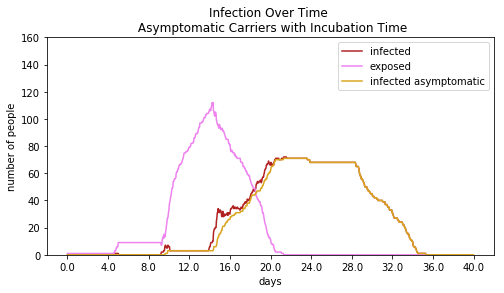

In [74]:
# Read in file
asympt_df = pd.read_csv(dataname, header=1)
print(asympt_df.columns)
asympt_df.head()
plt.figure(figsize=(8, 4))
plt.plot(asympt_df['time'],
                 asympt_df['infected'],
                 color='firebrick',
                 label='infected')
plt.plot(asympt_df['time'], asympt_df['exposed'], color='violet', label='exposed')
plt.plot(asympt_df['time'], asympt_df['infected asymptomatic'], color='goldenrod', label='infected asymptomatic')
plt.ylabel('number of people')
plt.xlabel('days')
plt.title('Infection Over Time \n Asymptomatic Carriers with Incubation Time')
plt.legend()
plt.xticks(np.linspace(0, N_steps, 11), np.linspace(0, 40, 11))
plt.ylim([0, n_agents])
plt.savefig('../../data/asymp_test_mask.png', dpi=100)
plt.show()

In [70]:
960/24

40.0